# DDPM

In [22]:
import copy
import logging
from types import SimpleNamespace
from contextlib import nullcontext


import wandb


import torch
from torch import optim
import torch.nn as nn
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar

from unet import UNet, EMA

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


In [5]:
config = SimpleNamespace(    
    run_name = "DDPM",
    epochs = 1,
    noise_steps=1000,
    seed = 42,
    batch_size = 16,
    img_size = 64,
    num_frames = 4,
    device = "cuda",
    use_wandb = True,
    do_validation = False,
    fp16 = True,
    num_workers=8,
    train_steps=1000,
    lr = 3e-4)

In [13]:
from torch_moving_mnist.utils import *
from torch_moving_mnist.data import MovingMNIST

In [14]:
affine_params = dict(
    angle=(-10, 10), # rotation in degrees (min and max values)
    translate=((-30, 30), (-30, 30)), # translation in pixels x and y
    scale=(.8, 1.3), # scaling in percentage (1.0 = no scaling)
    shear=(-20, 20), # deformation on the z-plane
)

ds = MovingMNIST(affine_params=affine_params, num_digits=[1,2], num_frames=config.num_frames*2)

New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])


In [16]:
imgs = ds[0]

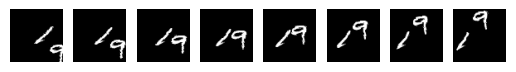

In [17]:
show_images(imgs)

In [18]:
b = ds.get_batch()
b.shape

torch.Size([32, 8, 1, 64, 64])

In [19]:
def get_batch(bs=config.batch_size, frames=config.num_frames, dim=1, device=config.device):
    b = ds.get_batch(bs).squeeze().to(device)
    return b.split(frames, dim=dim)

In [20]:
x,y = get_batch()

In [21]:
x.shape, y.shape

(torch.Size([16, 4, 64, 64]), torch.Size([16, 4, 64, 64]))

In [57]:
class FrameDiffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, c_in=8, c_out=4, use_wandb=False, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = UNet(c_in, c_out).to(device)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in
        self.use_wandb=use_wandb

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
    
    
    def noise_future(self, past_frames, future_frames, zero_past=False):
        noise = torch.randn_like(future_frames)
        if zero_past:
            return torch.cat([torch.zeros_like(past_frames), noise], dim=1)
        else:
            return torch.cat([past_frames, noise], dim=1)
    
    def int_image(self, x):
        x = (x.clamp(-1, 1) + 1) / 2
        return (x * 255).type(torch.uint8)
    
    @torch.inference_mode()
    def sample(self, use_ema):
        logging.info(f"Sampling new images....")
        model = self.ema_model if use_ema else self.model
        model.eval()
        with torch.inference_mode():
            past_frames, future_frames = get_batch()
            n = len(past_frames)
            x = torch.randn_like(future_frames)
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                all_frames = torch.cat([past_frames, x], dim=1)
                predicted_noise = model(all_frames, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        x = self.int_image(x)
        return torch.cat([self.int_image(past_frames), x], dim=1)

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def train(self, train_steps, use_wandb=False):
        self.model.train()
        pbar = progress_bar(range(train_steps))
        for i in pbar:
            if i % 10_000 == 0:
                self.log_images()
            with torch.autocast("cuda") if self.fp16 else nullcontext():
                past_frames, future_frames = get_batch()
                t = self.sample_timesteps(past_frames.shape[0]).to(self.device)  # batch size
                x_t, noise = self.noise_images(future_frames, t)
                all_frames = torch.cat([past_frames, x_t], dim=1)
                predicted_noise = self.model(all_frames, t)
                loss = self.mse(noise, predicted_noise)
                self.train_step(loss)
                if self.use_wandb:
                    wandb.log({"train_mse": loss.item(),
                               "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"MSE={loss.item():2.3f}"

    def log_images(self):
        "Log images to wandb and save them to disk"
        sampled_images = self.sample(use_ema=False)
        ema_sampled_images = self.sample(use_ema=True)
        def to_image(img):
            return wandb.Image(img.reshape(8*64, 64).transpose(1,0).cpu().numpy())
        wandb.log({"sampled_images":     [to_image(img) for img in sampled_images]})
        wandb.log({"ema_sampled_images": [to_image(img) for img in ema_sampled_images]})

    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))

    def save_model(self, run_name, use_wandb=False, epoch=-1):
        "Save model locally and on wandb"
        torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))
        if use_wandb:
            at = wandb.Artifact("model", type="model", description="Model weights for DDPM conditional", metadata={"epoch": epoch})
            at.add_dir(os.path.join("models", run_name))
            wandb.log_artifact(at)

    def prepare(self, args=None):
        self.train_steps = args.train_steps
        device = args.device
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, weight_decay=0.001)
        # self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr, 
        #                                          steps_per_epoch=args.train_steps, epochs=args.epochs)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=args.train_steps)
        self.mse = nn.MSELoss(reduction="sum")
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()

    def fit(self, args):
        self.train(args.train_steps, use_wandb=args.use_wandb)
            
            
        # self.save_model(run_name=args.run_name, use_wandb=args.use_wandb, epoch=epoch)

        # save model
        # self.save_model(run_name=args.run_name, use_wandb=args.use_wandb, epoch=epoch)

## Train

In [58]:
config.noise_steps = 1000

In [59]:
config.train_steps = 250_000

In [60]:
diffuser = FrameDiffusion(noise_steps=config.noise_steps, device=config.device, use_wandb=True)

In [ ]:
with wandb.init(project="ddpm_mmnist", group="train", config=config) if config.use_wandb else nullcontext():
    diffuser.prepare(config)
    diffuser.fit(config)

09:41:44 - INFO: Sampling new images....


In [ ]:
!sudo poweroff